In [59]:
#lets make all necessary imports
import os
import cv2
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [60]:
#lets check for number of data in each class for imbalance checking
covid_img = len(os.listdir("dataset/covid/")) # covid patients dataset
normal_img = len(os.listdir("dataset/normal/")) # normal patient dataset
print("No of covid_images: ", covid_img)
print("No of normal_images: ", normal_img)

No of covid_images:  25
No of normal_images:  25


In [61]:
#Both the classes have equal number of images but still the image count is very low
#lets set the path
imagePaths=list(paths.list_images('dataset/'))

In [62]:
img_data = []
label_data = []
for imagePath in imagePaths:
    #this would extract the labels as either "covid" or "normal"
    label = imagePath.split(os.path.sep)[-2].split('/')[-1]
    #reading the image
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224))
    
    img_data.append(img)
    label_data.append(label)

In [63]:
#now lets convert these list to numpy arrays
#image normalizing
img_data = np.array(img_data)/255.0
label_data = np.array(label_data)

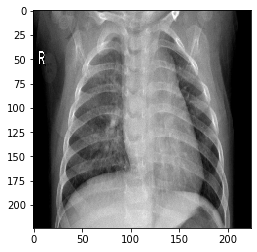

Label: normal


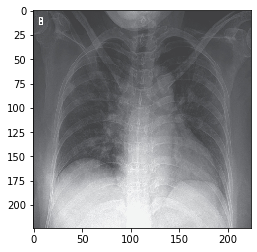

Label: covid


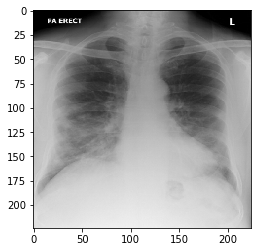

Label: covid


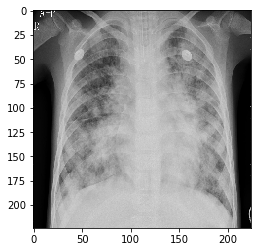

Label: normal


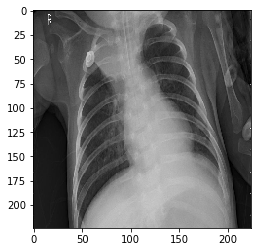

Label: normal


In [64]:
#Now lets plot a random image and its label
for i in range(5):
    idx = np.random.randint(1,50)
    plt.imshow(img_data[idx])
    plt.show()
    print(f"Label: {label_data[idx]}")

In [65]:
#For our loss function we need to perform one-hot encoding on the data
lbl = LabelBinarizer()
label_data = lbl.fit_transform(label_data)
label_data = to_categorical(label_data)
label_data.shape

(50, 2)

In [66]:
#Now let us split the data to train/test
X_train,X_test,y_train,y_test = train_test_split(img_data,
                                                 label_data,
                                                 test_size=0.2,
                                                 stratify=label_data,
                                                 random_state=42)

In [67]:
#data augmentation 
dataAug = ImageDataGenerator(rotation_range=30,zoom_range=0.5,
                            fill_mode='nearest')

In [84]:
#Lets try VGG16 architecture
base_model = VGG16(weights="imagenet",include_top=False,
                  input_tensor=Input(shape=(224,224,3)))

In [85]:
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [86]:
model = Model(inputs=base_model.input,outputs=headModel)

In [87]:
for layer in base_model.layers:
    layer.trainable= False

In [88]:
#few hyperparameters
lr = 1e-3
epochs = 15
batch_size = 5

In [89]:
model.compile(optimizer=Adam(decay = lr/epochs),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [90]:
hist = model.fit_generator(
        dataAug.flow(X_train,y_train,batch_size=batch_size),
        steps_per_epoch=len(X_train)//batch_size,
        validation_data=(X_test,y_test),
        validation_steps=(X_test)//batch_size,
        epochs=epochs)

Epoch 1/15
8/8 [==============================] - 2s 197ms/step - loss: 0.8573 - accuracy: 0.4250 - val_loss: 0.6767 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 1s 187ms/step - loss: 0.7083 - accuracy: 0.6000 - val_loss: 0.6785 - val_accuracy: 0.5000
Epoch 3/15
8/8 [==============================] - 2s 189ms/step - loss: 0.6929 - accuracy: 0.6000 - val_loss: 0.6575 - val_accuracy: 0.5000
Epoch 4/15
8/8 [==============================] - 1s 187ms/step - loss: 0.6457 - accuracy: 0.6250 - val_loss: 0.6531 - val_accuracy: 0.9000
Epoch 5/15
8/8 [==============================] - 1s 187ms/step - loss: 0.6838 - accuracy: 0.5750 - val_loss: 0.6472 - val_accuracy: 0.6000
Epoch 6/15
8/8 [==============================] - 1s 187ms/step - loss: 0.5700 - accuracy: 0.8000 - val_loss: 0.6319 - val_accuracy: 0.7000
Epoch 7/15
8/8 [==============================] - 1s 186ms/step - loss: 0.6245 - accuracy: 0.6500 - val_loss: 0.6097 - val_accuracy: 0.7000
Epoch 8/15
8/8 [====

In [91]:
preds = model.predict(X_test,batch_size=batch_size)

In [92]:
preds_idx = np.argmax(preds,axis=1)
preds_idx

array([1, 1, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

In [93]:
#classification report
print(classification_report(y_test.argmax(axis=1),preds_idx,
                     target_names=lbl.classes_))

              precision    recall  f1-score   support

       covid       0.80      0.80      0.80         5
      normal       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



In [94]:
cm = confusion_matrix(y_test.argmax(axis=1),preds_idx)
total = sum(sum(cm))
acc = (cm[0,0] + cm[1,1]) / total
sensitivity = cm[0,0]/(cm[0,0] + cm[0,1])
specificity = cm[1,1]/(cm[1,0] + cm[1,1])

In [95]:
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[4 1]
 [1 4]]
acc: 0.8000
sensitivity: 0.8000
specificity: 0.8000


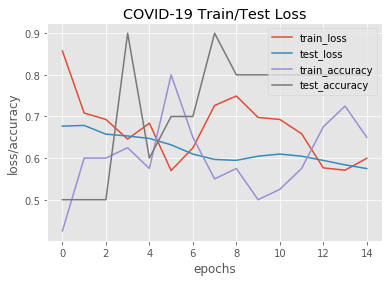

In [96]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N),hist.history["loss"],label="train_loss")
plt.plot(np.arange(0,N),hist.history["val_loss"],label="test_loss")
plt.plot(np.arange(0,N),hist.history["accuracy"],label="train_accuracy")
plt.plot(np.arange(0,N),hist.history["val_accuracy"],label="test_accuracy")
plt.title("COVID-19 Train/Test Loss")
plt.xlabel("epochs")
plt.ylabel("loss/accuracy")
plt.legend(loc="upper right")
plt.savefig("report.jpg")

dataset/covid\1-s2.0-S0140673620303706-fx1_lrg.jpg


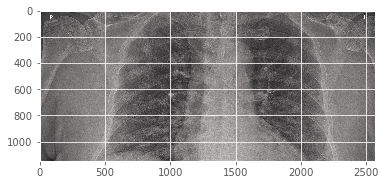

In [97]:
#Lets test the result
test_img = cv2.imread(imagePaths[0])
plt.imshow(test_img)
print(imagePaths[0])

In [98]:
test_img = cv2.resize(test_img,(224,224))
test_img= test_img / 255.0
res = model.predict(test_img.reshape(-1,224,224,3))
print("Prediction:",lbl.classes_[res.argmax(axis=1)])

Prediction: ['covid']


In [99]:
#Lets save the model
model.save("covid_vgg.h5")

In [106]:
#save the model
export_dir = "covid_19_model"
tf.saved_model.save(model,export_dir)

#lets choose optimization strategy
optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE

#convert model to lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimization = [optimization]
tflite_model= converter.convert()

INFO:tensorflow:Assets written to: covid_19_model\assets


In [107]:
#save the tflite model
with open("covid_19.tflite","wb") as f:
    f.write(tflite_model)

In [108]:
#Time to test the TFlite mode
interpreter = tf.lite.Interpreter(model_content = tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

normal


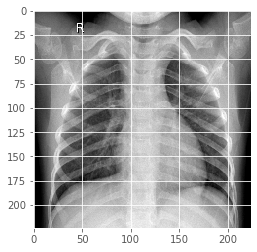

In [109]:
pred_img = X_test[1]
pred_label = y_test[1]
plt.imshow(pred_img)
print(lbl.classes_[np.argmax(pred_label)])

In [110]:
pred_img = pred_img.astype('float32')
interpreter.set_tensor(input_index, pred_img.reshape(-1,224,224,3))
interpreter.invoke()
res = interpreter.get_tensor(output_index)
lbl.classes_[np.argmax(res)]

'normal'